1. Загрузка датасета: скачайте датасет по ссылке, распакуйте его и разместите файлы в соответствующей структуре каталогов, чтобы можно было использовать DataLoader для загрузки данных.  

2. Обработка изображения: используйте библиотеку OpenCV для захвата кадров с веб-камеры и обработки изображения для детектирования лица на кадре. Для этого можно использовать готовые алгоритмы детектирования, такие как Haar Cascade Classifier или MTCNN.  

3. Подготовка данных: создайте DataLoader для загрузки данных из датасета, используя трансформации данных для предобработки их перед обучением модели.  

4. Разработка модели: определите архитектуру модели для классификации жестов рук на основе сверточной нейронной сети. Модель должна принимать на вход изображения размером, соответствующим размеру изображений в датасете, и выдавать предсказания для каждого класса жеста.  

5. Обучение модели: обучите модель на тренировочном наборе данных, используя оптимизатор и функцию потерь. Выполните оценку производительности модели на валидационном наборе данных во время обучения, чтобы отслеживать процесс обучения.  

6. Оценка модели: оцените производительность модели на тестовом наборе данных, чтобы определить ее точность и другие метрики.  

7. Интеграция модели: интегрируйте модель в приложение, чтобы она могла получать кадры из веб-камеры, обрабатывать их, детектировать жесты рук и классифицировать их.

In [49]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

In [50]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [51]:
data_dir = r'C:\Users\vmakh\OneDrive\Desktop\Python-20220419T075236Z-001\Python\PyTorch\Курсовая\Data\archive\leapGestRecog'
print(os.listdir(data_dir))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


Создадим директории train and test

In [52]:
import os
import random
import shutil

# Укажем главную директорию
main_dir = data_dir

# создадим директории train, test
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

# разбивка
split_ratio = 0.5

# идем по каждой папке
for person_folder in os.listdir(main_dir):
    person_folder_path = os.path.join(main_dir, person_folder)
    if not os.path.isdir(person_folder_path):
        continue

    # идем по жестам каждой персоны
    for gesture_folder in os.listdir(person_folder_path):
        gesture_folder_path = os.path.join(person_folder_path, gesture_folder)
        if not os.path.isdir(gesture_folder_path):
            continue

        # создадим папку жестов
        image_files = os.listdir(gesture_folder_path)

        # перемешаем
        random.shuffle(image_files)

        # разделим на train, test
        split_index = int(len(image_files) * split_ratio)
        train_files = image_files[:split_index]
        test_files = image_files[split_index:]

        # создадим директории train, test если их нет
        person_train_dir = os.path.join(train_dir, person_folder, gesture_folder)
        person_test_dir = os.path.join(test_dir, person_folder, gesture_folder)
        os.makedirs(person_train_dir, exist_ok=True)
        os.makedirs(person_test_dir, exist_ok=True)

        # скопируем тренировочные файлы в train 
        for train_file in train_files:
            src_file_path = os.path.join(gesture_folder_path, train_file)
            dst_file_path = os.path.join(person_train_dir, train_file)
            shutil.copy(src_file_path, dst_file_path)

        # скопируем тестировочные файлы в test
        for test_file in test_files:
            src_file_path = os.path.join(gesture_folder_path, test_file)
            dst_file_path = os.path.join(person_test_dir, test_file)
            shutil.copy(src_file_path, dst_file_path)


In [53]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
test Classes - ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [54]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
test_ds = ImageFolder(data_dir + '/test', test_tfms)

In [55]:
train_ds

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: C:\Users\vmakh\OneDrive\Desktop\Python-20220419T075236Z-001\Python\PyTorch\Курсовая\Data\archive\leapGestRecog/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

Определим размер батча:

In [82]:
batch_size = 10

И создадим наши даталоадеры:

In [83]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [84]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 240, 640])


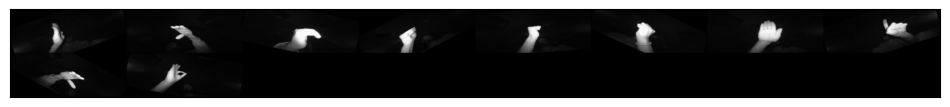

In [85]:
show_batch(train_dl)

Напишем функции для перевода наших Даталоадеров на необходимое оборудование:

In [86]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Узнаем какое оборудование у нас:

In [87]:
device = get_default_device()
device

device(type='cpu')

Воспользуемся функциями написанными выше:

In [88]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Шаг 2. Опишем модель

In [89]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [90]:
model = to_device(ResNet(1, len(classes_train)), device)

In [91]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Шаг 3. Обучение

In [92]:
torch.cuda.empty_cache()
history = []

epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [93]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

12 epochs, 1000 total_steps per epoch


In [95]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)


RuntimeError: [enforce fail at C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 786432000 bytes.

In [97]:
torch.save(model.state_dict(), './hand_gesture.pth')

In [99]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('./hand_gesture.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {outputs[0].argmax()}, groud truth - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

In [ ]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

cap = cv2.VideoCapture(0)  
    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = ResNet(1, 7).to(self.device)
        self.emodel.load_state_dict(torch.load('./models/emotion_detection_model_state.pth'))
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, landmarks, emotion):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'sad'
        elif digit == 1:
            return 'disgust'
        elif digit == 2:
            return 'happy'
        elif digit == 3:
            return 'surprise'
        elif digit == 4:
            return 'neutral'
        elif digit == 5:
            return 'fear'
        elif digit == 6:
            return 'angry'
       

    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                

        while True:
            ret, frame = cap.read()
            try:
                # detect face box, probability and landmarks
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

                face = self.crop_faces(frame, boxes)[0]
                face = cv2.resize(face,(48,48))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                emotion = self.emodel(torch_face[None, ...])
                emotion = self.digit_to_classname(emotion.argmax())

                # draw on frame
                self._draw(frame, boxes, probs, landmarks, emotion)

            except:
                pass

            # Show the frame
            cv2.imshow('Face Detection', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        
        
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()